## A/B-тестирование гипотез в онлайн-магазина

### Постановка задачи

Заказчиком исследования является интернет-магазин.

**Цель исследования** — приоритезировать маркетинговые гипотезы для увеличения выручки, запустить A/B-тест и проанализировать результаты.

### Описание данных

В нашем распоряжении имеются три датасета:

`hypothesis.csv` — датасет с перечнем гипотез

* `Hypothesis` — краткое описание гипотезы;
* `Reach` — оценка охвата пользователей по 10-балльной шкале;
* `Impact` — оценка влияния на пользователей по 10-балльной шкале;
* `Confidence` — оценка уверенности в гипотезе по 10-балльной шкале;
* `Efforts` — оценка затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем "дороже" проверка гипотезы.


`orders.csv` — датасет с данными о заказах интернет-магазина

* `order_id` — идентификатор заказа;
* `user_id` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.


`visitors.csv` — датасет с данными о посетителях

*  `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

### План исследования

* Импортировать библиотеки
* Загрузить данные
* Провести предобработку данных
* Применить фреймворк `ICE` для приоритизации гипотез;
* Применить фреймворк `RICE` для приоритизации гипотез.
* Построить графики кумулятивных значений выручки, среднего чека, среднего количества заказов по группам;
* Построить графики относительного изменения кумулятивных значений;
* Проанализировать аномальные значения: построить точечные графики количества заказов и их стоимостей, посчитать перцентили;
* Провести статистическую проверку гипотез о различиях в показателях между группами по сырым и очищенным данным, сделать выводы
* Сделать выводы по результатам теста

### Импортирование библиотек 

In [1]:
# Импортирование библиотек
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

# Игнорировать все предупреждения
warnings.filterwarnings("ignore")

# Зададим стиль для всех графиков
sns.set_style('darkgrid')

### Загрузка данных

Прочитаем данные с помощью функции `read_csv`.

In [2]:
# Загрузка данных
hypothesis = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_ab_test/hypothesis.csv')
orders = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_ab_test/orders.csv')
visitors = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_ab_test/visitors.csv')

# Зададим ширину колонок для корректного отображения
pd.options.display.max_colwidth = 130

Для каждого датасета выведем первые пять строк методом `head` и основую информацию методом `info`, для этого:

* Создадим словарь, в котором название датасета будет являться ключем, а датасет — значением.
* Напишем функцию, которая будет выводить первые пять строк датасета и основную информацию.
* Применим функцию к каждому элементу словаря с помощью цикла.

In [3]:
# Создание словаря с датасетами
datasets = {'hypothesis': hypothesis,
            'orders': orders,
            'visitors': visitors}

# Написание функции для выведения основной информации о датасете
def display_dataset_info(dataset_name, df, rows_num=5):
    display(f'Датасет {dataset_name}:')
    display(df.head(rows_num))
    display(df.info())

# Вызов функции для каждой пары элементов словаря
for dataset_name, dataset in datasets.items():
    display_dataset_info(dataset_name, dataset)


'Датасет hypothesis:'

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

'Датасет orders:'

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

'Датасет visitors:'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Данные успешно загружены.

По результатам метода `info` можно сделать следующие выводы:

* Во всех датасетах отсутствуют пропущенные значения;
* Названия столбцов нужно переписать в "змеином" стиле для удобства.
* Столбцы с датами в датасетах `visitors` и `orders` имеют неверный формат `object` — тип данных в этих столбцах нужно скорректировать на `datetime`;

### Предобработка данных

Переименуем названия столбцов в датасете `orders`.

In [4]:
# Переименование столбцов
orders = orders.rename(columns={'transactionId': 'order_id',
                                'visitorId': 'user_id'})

Скорректируем тип данных для столбцов с датами в датафреймах `orders` и `visitors`.

In [5]:
# Корректировка формата даты
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим датасеты на наличие дубликатов.

In [6]:
# Проверка датасетов на наличие дубликатов

for dataset_name, dataset in datasets.items():
    display (f'Количество дубликатов в датасете {dataset_name}')
    display (dataset.duplicated().sum())


'Количество дубликатов в датасете hypothesis'

0

'Количество дубликатов в датасете orders'

0

'Количество дубликатов в датасете visitors'

0

Во всех датасетах дубликаты отсутствуют.

Проверим изменения, снова вызовем функцию `display_dataset_info`.

In [7]:
# "Обновим" значения словаря
datasets = {'hypothesis': hypothesis,
            'orders': orders,
            'visitors': visitors}

# Вызовем функцию для каждого датасета
for dataset_name, dataset in datasets.items():
    display_dataset_info(dataset_name, dataset)

'Датасет hypothesis:'

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

'Датасет orders:'

,order_id,user_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   order_id  1197 non-null   int64         
 1   user_id   1197 non-null   int64         
 2   date      1197 non-null   datetime64[ns]
 3   revenue   1197 non-null   int64         
 4   group     1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

'Датасет visitors:'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

Изменения успешно внесены – типы данных скорректированы, стобцы переименованы. Данные готовы для анализа.

### Приоритизация гипотез

Проведем приоритезацию гипотез методом ICE, для этого:

* Добавим в датасет с гипотезами значение ICE, рассчитанный по формуле: `(Impact * Confidence) / Efforts`
* Отсортируем гипотезы по убыванию значения ICE для выявления наиболее приоритетных гипотез

In [8]:
# Добавим столбец ICE и округлим значения до двух знаков после запятой
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / 
                          hypothesis['Efforts'], 2)

# Отсортируем гипотезы по убыванию значения ICE
display (hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Согласно фреймворку ICE, наиболее приоритеными являются следующие гипотезы:

* Запустить акцию, дающую скидку на товар в день рождения
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок




Теперь применим фреймворк `RICE`, который включает параметр `Reach` — оценку количества пользователей, на которых повлияет изменение, для этого:

* Добавим значение RICE, рассчитанный по формуле: `(Reach * Impact * Confidence) / Efforts`
* Отсортируем гипотезы по убыванию значения RICE

In [9]:
# Добавим столбец RICE
hypothesis['RICE'] = ((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) 
                      / hypothesis['Efforts'])

# Отсортируем гипотезы по убыванию значения RICE
display (hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Тройка наиболее приоритетных гипотез после применения фреймворка RICE изменилась, на этот раз самыми приоритетными являются следующие гипотезы:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Вывод:** проведем A/B-тестирование добавления формы подписки на основные страницы — эта гипотеза с большим отрывом имеет самый высокий приоритет по значению RICE в сравнении с остальными гипотезами.


### Проведение A/B-теста

Проведем A/B-тест по данным о заказах и посетителях интернет-магазина. 

Для начала проанализируем основные показатели по группам, простроим следующие графики:

* График кумулятивной выручки по группам;
* График кумулятивного среднего чека по группам;
* График относительного изменения кумулятивного среднего чека группы B к группе A;
* График кумулятивного среднего количества заказов на посетителя по группам;
* График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;

#### Анализ кумулятивных данных

Подготовим данные для построения графиков — создадим агрегированный датасет с накопленными данными по количеству заказов, количеству покупателей, выручке и количеству пользователей.

In [10]:
# Создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# Получим агрегированные кумулятивные данные о заказах по дням
orders_aggregated = (dates_groups.apply(lambda x:
                                        orders[np.logical_and(orders['date'] <= x['date'],
                                               orders['group'] == x['group'])]
                                 .agg({'date' : 'max',
                                       'group' : 'max',
                                       'order_id' : 'nunique',
                                       'user_id' : 'nunique',
                                       'revenue' : 'sum'}), axis=1)
                                 .sort_values(by=['date','group']))

# Получим агрегированные кумулятивные данные по дням о посетителях интернет-магазина 
visitors_aggregated = (dates_groups.apply(lambda x:
                                          visitors[np.logical_and(visitors['date'] <= x['date'],
                                          visitors['group'] == x['group'])]
                            .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                            .sort_values(by=['date','group']))

# Объединяем кумулятивные данные в одной таблице
cumulative_data = orders_aggregated.merge(visitors_aggregated,
                                          left_on=['date', 'group'],
                                          right_on=['date', 'group'])

# Просвоим столбцам датасета понятные названия
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Выведем результат
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Датасет собран, теперь построим график кумулятивной выручки по группам.

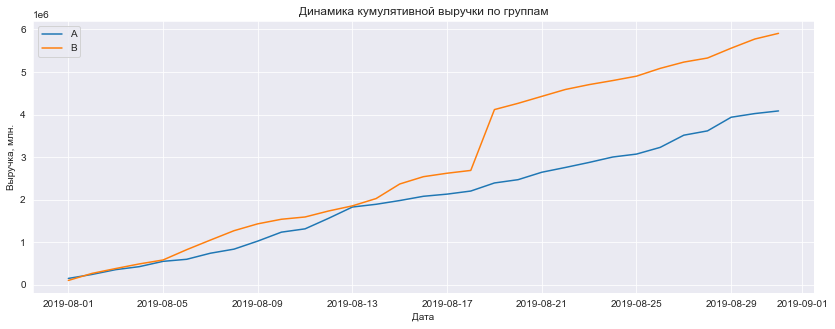

In [11]:
# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Зададим размер графика
plt.figure(figsize=(14, 5))

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# Добавление подписей и легенды
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Выручка, млн.')
plt.title('Динамика кумулятивной выручки по группам')

# Выведение графика
plt.show()


Кумулятивная выручка группы B резко выросла после 17 августа. Всплеск, вероятно, связан с резким увеличением среднего чека или конверсии в покупку, которые в свою очередь могли вырасти по разным причинам — например, кто-то в группе B мог купить очень дорогой товар или пользователи купили много товаров.


Рассмотрим динамику кумулятивного среднего чека по группам — построим линейный график.

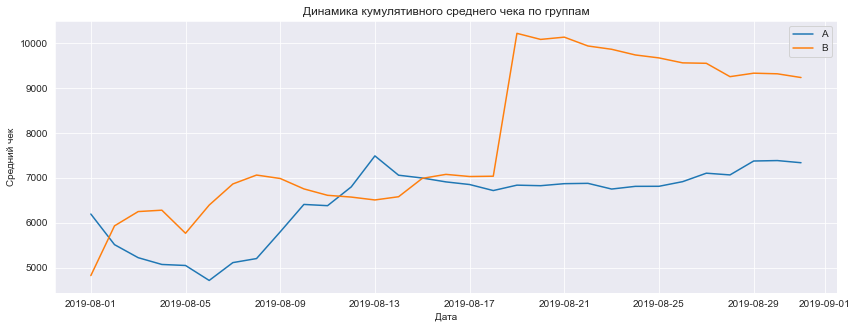

In [12]:
# Зададим размер графика
plt.figure(figsize=(14, 5))

# Строим график среднего чека группы А
# Средний чек посчитаем через отношение выручки к количеству заказов
plt.plot(cumulative_revenue_a['date'],
         cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulative_revenue_b['date'],
         cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

# Добавление подписей и легенды
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Динамика кумулятивного среднего чека по группам')

# Выведение графика
plt.show()

По среднему чеку также заметен всплеск после 17 августа. В целом группа B также превосходит группу А по среднему чеку, однако, это опережение не такое стабильное, как в выручке: например, 13 августа средний чек группы A вырвался вперед относительно среднего чека группы B. Также видно, что с 25 августа средний чек группы B медленно падает, а средний чек группы A, наоборот, медленно растет.

Рассмотрим изменение кумулятивного среднего чека в группе B относительного группы A.

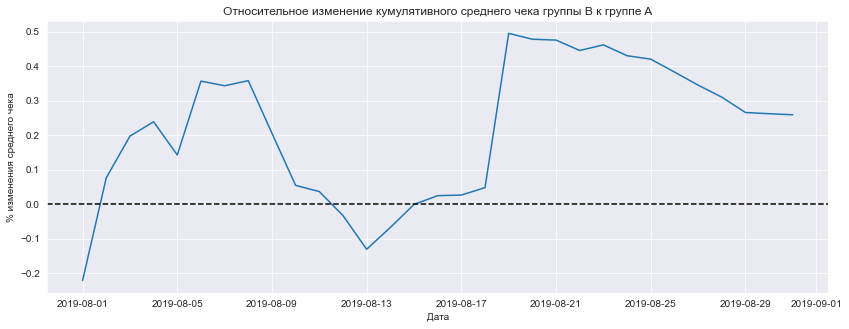

In [13]:
# Собираем данные по группам в одном датафрейме
merged_cumulative_revenue = (cumulative_revenue_a.merge(cumulative_revenue_b,
                                                        left_on='date',
                                                        right_on='date',
                                                        how='left',
                                                        suffixes=['A', 'B']))
# Зададим размер графика
plt.figure(figsize=(14, 5))

# Строим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],
        (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])
         /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# Добавляем ось X с нулевым изменением (для удобства в сравнении)
plt.axhline(y=0, color='black', linestyle='--');

# Добавление подписей и легенды
plt.xlabel('Дата')
plt.ylabel('% изменения среднего чека')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A');

# Выведение графика
plt.show()

График относительного изменения кумулятивного среднего чека подтверждает выводы предыдущего графика — нельзя однозначно сказать о лидерстве одной из групп. На протяжении всего анализируемого периода происходят резкие всплески и падения изменения среднего чека в группе B относительно группы A.

Изучим среднее количество заказов на пользователя — также построим кумулятивный график.

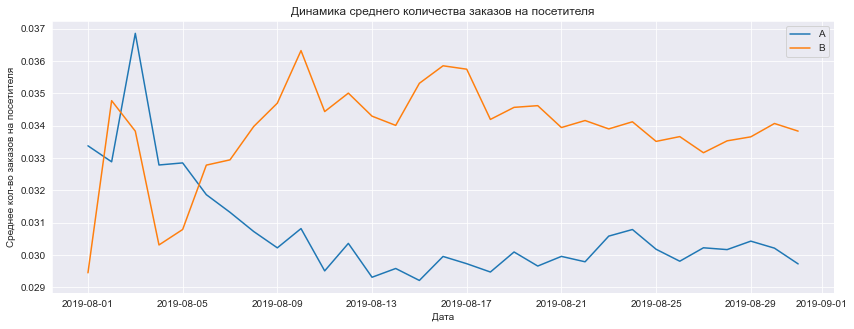

In [14]:
# Считаем кумулятивную конверсию — количество заказов на пользователя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# Отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# Отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# Зададим размер графика
plt.figure(figsize=(14, 5))

# Строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

# Добавление подписей и легенды
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов на посетителя')
plt.title('Динамика среднего количества заказов на посетителя');

# Выведение графика
plt.show()

На неделе с 5 августа среднее количество заказов на пользователя в группе B превысило среднее количество заказов на пользователя в групппе А, после чего лидерство группы B остается относительно стабильным. Посмотрим на график относительного изменения этого показателя в группе B к группе A.

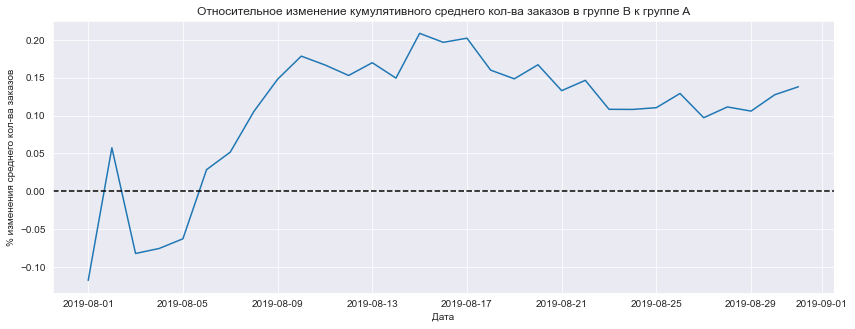

In [15]:
# Объединение датафреймов с конверсиями
merged_cumulative_conversions = (cumulative_data_a[['date','conversion']]
                                 .merge(cumulative_data_b[['date','conversion']],
                                        left_on='date',
                                        right_on='date',
                                        how='left',
                                        suffixes=['A', 'B']))

# Зададим размер графика
plt.figure(figsize=(14, 5))

# Строим графики
plt.plot(merged_cumulative_conversions['date'],
         merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)


# Добавляем ось X с нулевым изменением (для удобства в сравнении)
plt.axhline(y=0, color='black', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('% изменения среднего кол-ва заказов')
plt.title('Относительное изменение кумулятивного среднего кол-ва заказов в группе B к группе A');


График относительного изменения метрики подтверждает выводы выше — среднее количество заказов на пользователя в группе B стабильно выше, чем в группе А.

#### Обработка аномальных значений

Для улучшения качества результатов A/B-теста изучим выбросы и аномальные значения в выборке — посмотрим, сколько заказов приходится на пользователя и построим точечный график.

In [16]:
# Сгруппируем датасет с заказами по пользователям, агрегируем данные по количеству заказов
orders_by_users = orders.groupby('user_id', as_index=False).agg({'order_id': 'nunique'})

# Переименуем названия столбцов
orders_by_users.columns = ['user_id', 'orders']

# Отсортируем таблицу по убыванию и выведем первые строки
orders_by_users.sort_values(by='orders', ascending=False).head()

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Теперь построим точечный график с распределением количества заказов на пользователя.

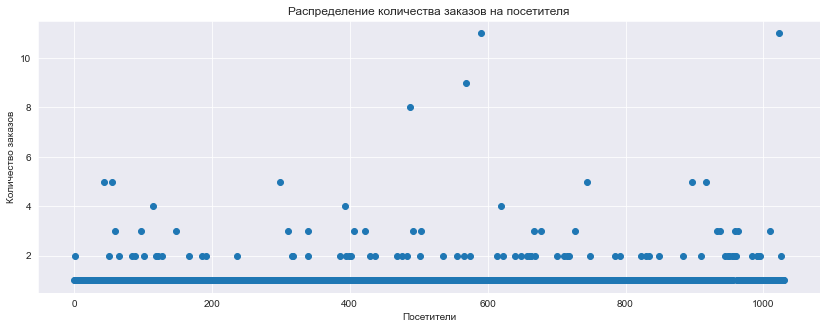

In [17]:
# Зададим ось Х
x_values = pd.Series(range(0,len(orders_by_users)))

# Зададим размер графика
plt.figure(figsize=(14, 5))

# Построим график
plt.scatter(x_values, orders_by_users['orders'])

# Зададим подписи
plt.xlabel('Посетители')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов на посетителя');


Большинство пользователей совершает до двух заказов, реже — до четырех. Есть пользователи, которые совершают аномально большое количество заказов — от восьми и выше. 

Посчитаем 95-й и 99-й перцентили для определения границы очистки выборки.

In [18]:
# Расчет перцентилей
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершают два и более заказа , в будущем примем это значение в качестве верхней границы для удаления аномальных данных. 

Теперь рассмотрим распределение стоимостей заказов на точечном графике.

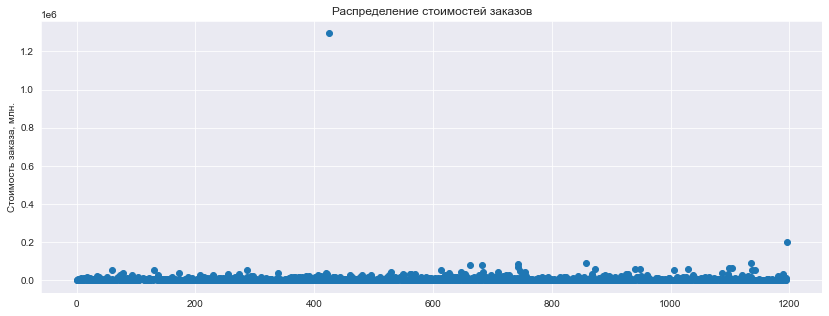

In [19]:
# Зададим ось Х
x_values = pd.Series(range(0,len(orders['revenue'])))

# Зададим размер графика
plt.figure(figsize=(14, 5))

# Построим график
plt.scatter(x_values, orders['revenue'])

# Зададим подписи
plt.xlabel('')
plt.ylabel('Стоимость заказа, млн.')
plt.title('Распределение стоимостей заказов');


На графики четко определяются два аномально дорогих заказа — кто-то совершил заказ на сумму более 1 млн. рублей. Вероятно, эти аномально дорогие заказы повлияли на всплески кумулятивной выручки и кумулятивного среднего чека в группе B — для улучшения качества результатов теста эти выбросы следует удалить.

Для большей наглядности рассмотрим график без аномально высоких значений — ограничим значения по оси Y до 120 тыс. рублей.

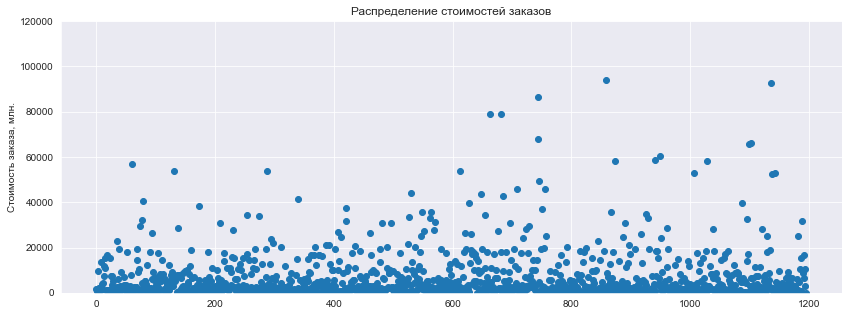

In [20]:
# Зададим ось Х
x_values = pd.Series(range(0,len(orders['revenue'])))

# Зададим размер графика
plt.figure(figsize=(14, 5))

# Построим график
plt.scatter(x_values, orders['revenue'])

# Зададим подписи
plt.xlabel('')
plt.ylim(0, 120000)
plt.ylabel('Стоимость заказа, млн.')
plt.title('Распределение стоимостей заказов');


По исправленному графику видно, что стоимость большинства заказов редко превышает 40 тыс. рублей.

Посчитаем перцентили выручки для определения границы очистки данных.

In [21]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Только в 5% случаев стоимость заказа превышает 28 000 рублей, в будущем примем эту сумму в качестве верхней границы нормальных значений. 


#### Подготовка данных

Подготовим данные для A/B-теста — в отдельный датасет для каждой группы соберем количество заказов, суммарную выручку и число посетителей магазина по дням. Каждую метрику рассмотрим как за один день, так и с накоплением.

In [22]:
# Выделим пользователей из группы А в отдельный датафрейм
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]

# Переименуем столбцы
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# Соберем кумулятивное число пользователей в группе А по дням
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}),axis=1)

# Переименуем столбцы
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

# То же самое сделаем для группы B
# Соберем кумулятивное число пользователей в группе B по дням
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# Соберем кумулятивное число пользователей в группе B по дням
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}),axis=1)

# Переименуем столбцы
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

# Соберем данные по заказам для группы А
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': 'nunique', 'revenue': 'sum'}))

# Переименуем столбцы
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# Соберем накопленные данные по заказкам для группы А
orders_a_cummulative = (orders_a_daily.apply(
         lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}),axis=1)
        .sort_values(by=['date']))

# Переименуем столбцы
orders_a_cummulative.columns = ['date',
                                'orders_сummulative_a',
                                'revenue_cummulative_a']

# Соберем данные по заказам для группы B
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': 'nunique', 'revenue': 'sum'}))

# Переименуем столбцы
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# Соберем накопленные данные по заказкам для группы B
orders_b_cummulative = (orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}),axis=1)
        .sort_values(by=['date']))
                        
# Переименуем столбцы
orders_b_cummulative.columns = [
    'date',
    'orders_сummulative_b',
    'revenueCummulativeB']

# Соберем все данные в один датасет
data = (orders_a_daily.merge(
    orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left'))

# Выведем результат
data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_сummulative_a,revenue_cummulative_a,orders_сummulative_b,revenueCummulativeB,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Данные собраны корректно.

Создадим переменные `orders_by_users_a` и `orders_by_users_b`. В них для пользователей, которые заказывали хотя бы один раз, укажем число совершённых заказов. 

In [23]:
# Соберем датасет с количеством заказов на каждого пользователя в группе А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('user_id', as_index=False)
    .agg({'order_id': 'nunique'}))

# Переименуем столбцы
orders_by_users_a.columns = ['user_id', 'orders']

# Соберем датасет с количеством заказов на каждого пользователя в группе В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('user_id', as_index=False)
    .agg({'order_id': 'nunique'}))

# Переименуем столбцы
orders_by_users_b.columns = ['user_id', 'orders']

Объявим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы потом сравнить доли.

In [24]:
sample_a = (pd.concat([orders_by_users_a['orders'],
                       pd.Series(0,index=np.arange(data['visitors_per_date_a'].sum() 
                       - len(orders_by_users_a['orders'])), name='orders')],axis=0))
           
           
sample_b = (pd.concat([orders_by_users_b['orders']
                       ,pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum()
                       - len(orders_by_users_b['orders'])), name='orders')],axis=0))
           
           

#### Проведение статистических тестов

Напишем функцию для расчета статистической значимости критерием Манна-Уитни.

In [25]:
def stat_significance(a, b):
    
    alpha = 0.05 # Зададим значение alpha
    p_value = stats.mannwhitneyu(a, b)[1] # Расчет p-value
    print("P-value: {0:.3f}".format(p_value)) # Выведем p-value
    
    # Выведем результат проверки гипотезы
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    
    # Выведем прирост в группе B относительно группы А
    print("Относительный прирост В к А: {0:.3%}".format(b.mean() / a.mean()-1))

Проведем статистический тест по исходным данным — сравним отличия среднего количества заказов на посетителя в группах А и В. Сформулируем нулевую и альтернативную гипотезы:

* H0: В среднем количестве заказов на посетителя в группах А и В нет статистически значимых отличий
* H1: Среднее количество заказов на посетителя в группах А и В отличается


In [26]:
# Статистическая проверка отличий в среднем количестве заказов 
stat_significance(sample_a, sample_b)

P-value: 0.017
Отвергаем нулевую гипотезу
Относительный прирост В к А: 13.808%


Относительный прирост количества заказов на пользователя в группе B равен 13,8%. Различия в среднем количестве заказов на посетителя между группами статистически значимы. Вероятность случайно получить такое или большее различие (`p-value`) менее 0,05. 

Теперь проверим различия между группами в среднем чеке, также по исходным данным. Сформулироем гипотезы:

* H0: Между средними чеками в группах А и В нет отличий
* H1: Средние чеки в группах А и В отличаются

In [27]:
# Статистическая проверка отличий в средних чеках
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительный прирост В к А: 25.871%


Нулевую гипотезу не получилось отвернуть — нет оснований считать различия в средних чеках статистически значимыми. Относительный прирост среднего чека в группе B составляет более 25% — вероятность получить такое значение более 0,05

Теперь проведем статистические тесты по очищенным данным. В качестве верхней границы количества заказов примим число 2, которое мы определили выше на этапе обработки аномальных значений, в качестве верхней границы стоимости заказа — 28 000 рублей. Сделаем сответствующий срез по аномальным значениям.

In [28]:
# Запишем границы очистки данных в отдельные переменные 
abnormal_order_number = 2
abnormal_revenue = 28000

# Выделим пользователей с аномально высоким числом заказов 
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > abnormal_order_number]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > abnormal_order_number]['user_id'],
    ],axis=0)

# Выделим пользователей с аномально дорогими заказами
users_with_expensive_orders = orders[orders['revenue'] > abnormal_revenue]['user_id']

# Выделим всех аномальных пользователей в отдельную переменную
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormal_users.head())
print(abnormal_users.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: user_id, dtype: int64

74


В данных 74 аномальных пользователя — соберем датасеты с выборками по очищенным данным, без аномальных пользователей.

In [29]:
# Подготовим выборку для группы А по очищенным данным
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            # исключение аномальных пользователей
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users)) 
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Подготовим выборку для группы B по очищенным данным
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            # исключение аномальных пользователей
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users)) 
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по очищенным данным.

In [30]:
# Статистическая проверка отличий в количестве заказов на пользователя 
stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.013
Отвергаем нулевую гипотезу
Относительный прирост В к А: 17.270%


По сравнению с сырыми данными результаты почти не изменились: `p-value` немного снизилась, относительная разница в группе B выросла с 13,8% до 17,3%. Выводы остались прежними — отличия в группах по среднему количеству заказов статистически значимо.

Теперь по очищенным данным изучим статистическую значимость различий в средних чеках.

In [31]:
# Запишем срез по очищенным данным для группы А
filtered_revenue_a = (orders[np.logical_and(orders['group'] == 'A',
                            np.logical_not(orders['user_id'].isin(abnormal_users)))]['revenue'])

# Запишем срез по очищенным данным для группы В
filtered_revenue_b = (orders[np.logical_and(orders['group'] == 'B',
                            np.logical_not(orders['user_id'].isin(abnormal_users)))]['revenue'])

# Статистическая проверка отличий в средних чеках
stat_significance(filtered_revenue_a, filtered_revenue_b)

P-value: 0.738
Не получилось отвергнуть нулевую гипотезу
Относительный прирост В к А: -1.962%


Уровень статистической значимости почти не изменился: `p-value` по-прежнему выше 0,05. Следовательно, у нас нет оснований, чтобы отвергнуть нулевую гипотезу. Различия в средних чеках между группами по-прежнему не значимо.

### Выводы

В ходе исследования был проведен анализ на основании трех источников данных: датасета с гипотезами, датасета с информацией о заказах и датасета с инфорамацией о посетителях онлайн-магазина.

**Основные выводы по приоритезации гипотез:**

Согласно фреймворку ICE, наиболее приоритетными следующие гипотезы:

* Запустить акцию, дающую скидку на товар в день рождения
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

По фреймворку RICE, наиболее приоритеные гипотезы:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Основные выводы по A/B-тесты:**

* Кумулятивная выручка группы B резко выросла после 17 августа. Всплеск связан с резким увеличением среднего чека и конверсии в покупку, которые в свою очередь могли вырасти по разным причинам — например, кто-то в группе B мог купить очень дорогой товар или пользователи купили аномально большое количество товаров.
* По среднему чеку также заметен всплеск после 17 августа. Группа B превосходит группу А по среднему чеку, однако, это опережение не такое стабильное, как в выручке: например, 13 августа средний чек группы A вырвался вперед относительно среднего чека группы B. Также видно, что с 25 августа средний чек группы B медленно падает, а средний чек группы A, наоборот, медленно растет.
* На неделе с 5 августа среднее количество заказов на пользователя в группе B превысило среднее количество заказов на пользователя в групппе А, после чего лидерство группы B остается относительно стабильным. 
* Среднее количество заказов в группе В статистически значимо выше, чем в группе А — как по данным без фильтрации, так и по данным с исключением аномальных значений. По очищенным данным относительный прирост в группе B составляет 17.27%
* По графику относительного изменения кумулятивного среднего чека группа B лидирует, но это лидерство статистически не значимо. К тому же, разрыв между группами сокращается.